In [1]:
# Import peartree and log version
import peartree as pt
pt.__version__

'0.6.4'

In [2]:
# Also note NetworkX version
import networkx as nx
nx.__version__

'2.3'

In [3]:
# Ensure that the GTFS we want to work with is
# loaded, available locally
import os
assert 'nola_gtfs.zip' in os.listdir()

AssertionError: 

In [4]:
feed = pt.get_representative_feed('data/nola_gtfs.zip')

In [5]:
start = 7 * 60 * 60
end = 9 * 60 * 60
%time G = pt.load_feed_as_graph(feed, start, end)

CPU times: user 19.9 s, sys: 179 ms, total: 20 s
Wall time: 20 s


In [6]:
import matplotlib as mpl
mpl.__version__

'3.4.1'

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

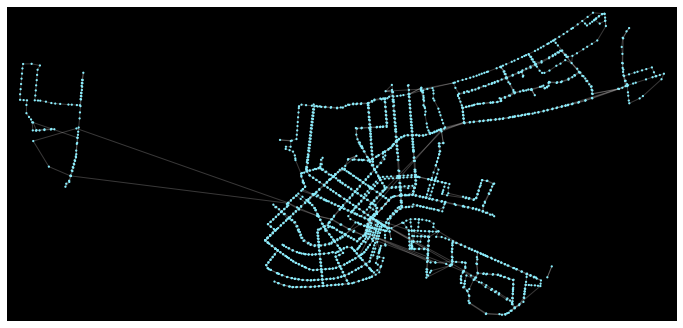

In [7]:
%matplotlib inline
pt.plot.generate_plot(G)

In [8]:
# Get osm network graph via OSMnx
import osmnx as ox
ox.__version__

'1.0.1'

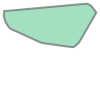

In [9]:
import geopandas as gpd
from shapely.geometry import Point

# We need a coverage area, based on the points from the
# New Orleans GTFS data, which we can pull from the peartree
# network graph by utilizing coordinate values and extracting
# a convex hull from the point cloud
boundary = gpd.GeoSeries(
    [Point(n['x'], n['y']) for i, n in G.nodes(data=True)]
    ).unary_union.convex_hull

# Visually inspect
boundary

In [10]:
# Pull in the walk network with OSMnx
%time Gwalk = ox.graph_from_polygon(boundary, network_type='walk')

CPU times: user 34.2 s, sys: 621 ms, total: 34.9 s
Wall time: 35 s


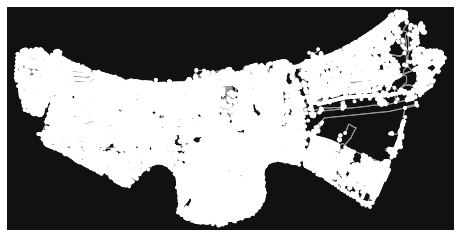

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [11]:
# Visually inspect (takes a minute or two)
ox.plot_graph(Gwalk)

In [12]:
# Note the edge structure of the peartree graph
list(G.edges(data=True))[0]

('6F0F2_1', '6F0F2_1621', {'length': 65.0, 'mode': 'transit'})

In [13]:
# ...and that of the OSMnx graph
list(Gwalk.edges(data=True))[0]

(115481154,
 115481159,
 {'osmid': 12649166,
  'name': 'Homestead Avenue',
  'highway': 'residential',
  'oneway': False,
  'length': 252.612})

In [14]:
%%time

# Edge length in peartree is represented in seconds
# while in OSMnx it is in meters, so we need to convert those values
# down to seconds, based on some walk speed
walk_speed = 4.5  # about 3 miles per hour

# Make a copy of the graph in case we make a mistake
Gwalk_adj = Gwalk.copy()

# Iterate through and convert lengths to seconds
for from_node, to_node, edge in Gwalk_adj.edges(data=True):
    orig_len = edge['length']
    
    # Note that this is a MultiDiGraph so there could
    # be multiple indices here, I naively assume this is not
    # the case
    Gwalk_adj[from_node][to_node][0]['orig_length'] = orig_len

    # Conversion of walk speed and into seconds from meters
    kmph = (orig_len / 1000) / walk_speed
    in_seconds = kmph * 60 * 60
    Gwalk_adj[from_node][to_node][0]['length'] = in_seconds
    
    # And state the mode, too
    Gwalk_adj[from_node][to_node][0]['mode'] = 'walk'

CPU times: user 1.45 s, sys: 4.99 ms, total: 1.45 s
Wall time: 1.45 s


In [15]:
# Ensure that we now have both length values (and
# thus an updated edge schema)
list(Gwalk_adj.edges(data=True))[0]

(115481154,
 115481159,
 {'osmid': 12649166,
  'name': 'Homestead Avenue',
  'highway': 'residential',
  'oneway': False,
  'length': 202.0896,
  'orig_length': 252.612,
  'mode': 'walk'})

In [17]:
# Now we have to do the same thing for the nodes as well

# Here is the GTFS node from NOLA
list(G.nodes(data=True))[0]

('6F0F2_1',
 {'boarding_cost': 425.0, 'modes': ['0'], 'y': 29.960899, 'x': -90.05716})

In [18]:
# As you can see we are missing the
# boarding cost for the walk network nodes (which
# is just zero)
list(Gwalk_adj.nodes(data=True))[0]

(115481154, {'y': 29.997133, 'x': -90.138244, 'street_count': 3})

In [19]:
# So this should be easy - just go through all nodes
# and make them have a 0 cost to board
for i, node in Gwalk_adj.nodes(data=True):
    Gwalk_adj.node[i]['boarding_cost'] = 0

In [20]:
# Now that we have a formatted walk network
# it should be easy to reload the peartree graph
# and stack it on the walk network
start = 7 * 60 * 60
end = 9 * 60 * 60

# Note this will be a little slow - an optimization here would be
# to have coalesced the walk network
%time G2 = pt.load_feed_as_graph(feed, start, end, existing_graph=Gwalk_adj)

CPU times: user 1min 28s, sys: 4.11 s, total: 1min 33s
Wall time: 1min 35s


In [21]:
# This is an issue that needs cleaning up
# slash I need to look into it more
# but some nodes that should have been
# cleaned out remain
print('All nodes', len(G2.nodes()))
bad_ns = [i for i, n in G2.nodes(data=True) if 'x' not in n]
print('Bad nodes count', len(bad_ns))

for bad_n in bad_ns:
    # Make sure they do not conenct to anything
    if len(G2[bad_n]) > 0:
        # This should not happen
        print(bad_n)

    else:
        # So just drop them
        G2.remove_node(bad_n)

All nodes 47923
Bad nodes count 4763


(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

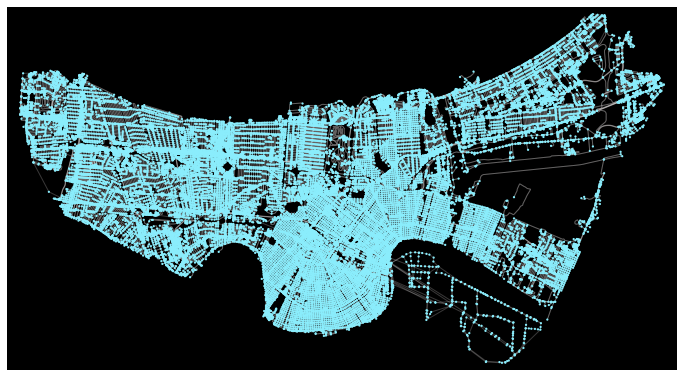

In [22]:
pt.plot.generate_plot(G2)

In [23]:
G2

In [44]:
from ds import get_shortest_pair, nearest_k_nodes, get_route_length

In [45]:
elw = (29.923660367925944, -90.08639225392868)
dwn = (29.953456154341655, -90.06947757268863)
wre = (29.921405607105605, -90.11278871690588)

In [74]:
route, dist = get_shortest_pair(G2, elw, wre, k=4)

In [73]:
route

['X5R61_611',
 'X5R61_612',
 'X5R61_615',
 'X5R61_617',
 'X5R61_622',
 'X5R61_628',
 'X5R61_637',
 'X5R61_1626',
 'X5R61_648',
 'X5R61_649',
 'X5R61_650',
 'X5R61_651',
 'X5R61_658']

In [101]:
G2["X5R61_1626"]

AdjacencyView({'X5R61_648': {0: {'length': 41.0, 'mode': 'transit'}}, 'X5R61_323': {0: {'length': 47.0, 'mode': 'transit'}}})

In [90]:
G2.nodes.get("X5R61_1626")

{'boarding_cost': 400.0, 'modes': ['3'], 'y': 29.920694, 'x': -90.101676}

In [94]:
G2.nodes.get(116029591)

{'y': 29.920782, 'x': -90.101595, 'street_count': 4, 'boarding_cost': 0}

In [92]:
nearest_k_nodes(G2, -90.101676, 29.920694, k=10, return_dist=True)

(['X5R61_1626',
  116029591,
  'X5R61_849',
  116029587,
  'X5R61_1365',
  116019416,
  3346653470,
  3346653471,
  3344145541,
  3344145542],
 [0.0,
  12.517526503758422,
  20.582149510189787,
  32.69699861760831,
  38.7687675791543,
  101.73489526443983,
  104.26564294805608,
  108.71667414104937,
  120.17180304024089,
  123.87805056472938])

In [102]:
route, dist = get_shortest_pair(G2, elw, wre, k=4)

In [104]:
route

['X5R61_611',
 'X5R61_612',
 'X5R61_615',
 'X5R61_617',
 'X5R61_622',
 'X5R61_628',
 'X5R61_637',
 'X5R61_1626',
 'X5R61_648',
 'X5R61_649',
 'X5R61_650',
 'X5R61_651',
 'X5R61_658']

In [103]:
ox.plot_route_folium(G2, route)

In [47]:
point = elw 
X, Y = point[1], point[0]

In [48]:
nearest_k_nodes(G, X, Y, k=3, return_dist=False)

/Users/filip/code/anaconda3/envs/trox/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


['6F0F2_1946', '6F0F2_611', '6F0F2_368']